[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Ware_et_al_2025/fig_5.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Ware_et_al_2025/fig_5.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Ware_et_al_2025/fig_5.ipynb)

# Fig. 5 in [Ware et al. 2025](https://doi.org/10.48550/arXiv.2509.05536)

In [ ]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [1]:
import os
import numpy as np
from matplotlib import pyplot
from PySDM_examples.Ware_et_al_2025.example import run, Settings, SpectrumPlotter
from PySDM.initialisation.sampling.spectral_sampling import AlphaSampling
from PySDM.backends import CPU
from open_atmos_jupyter_utils import show_plot

In [5]:
backend = CPU()

def dist_1_inv(y, volume_range):
    radius_range = [backend.formulae.trivia.radius(v) for v in volume_range]
    return backend.formulae.trivia.volume(radius=(radius_range[1] - radius_range[0]) * y + radius_range[0])

n_sd = 16
dt = 20
alphas = np.linspace(0, 1, 6)
n_iters = 2 if 'CI' in os.environ else 10

errors_all = {}
errors_std_all = {}

for sampling in ('deterministic','quasirandom','pseudorandom'):
    for adaptive in (False, True):
        errors_all[f'{adaptive}_{sampling}'] = []
        errors_std_all[f'{adaptive}_{sampling}'] = []
        for k,alpha in enumerate(alphas):

            plotter = SpectrumPlotter(Settings(), legend=False)
            plotter.smooth = False

            errors = []
            outputs = []
            exec_times = []

            for it in range(n_iters):
                settings = Settings()
                backend.formulae.seed = it

                settings.n_sd = 2**n_sd
                settings.dt = dt 
                settings.adaptive = adaptive

                settings.sampling = AlphaSampling(
                    settings.spectrum,
                    alpha=alpha,
                    dist_1_inv=dist_1_inv,
                    interp_points=10000,
                )
                states, exec_time, _ = run(settings, backend, sampling_method=sampling)
                print(f"{dt=}, {n_sd=}, {exec_time=}, {it=}")
                outputs.append(states)
                for step, vals in states.items():
                    error = plotter.plot(vals, step * settings.dt)
                errors.append(error)

            mean_output = {}

            for key in outputs[0].keys():
                mean_output[key] = sum((output[key] for output in outputs)) / len(
                    outputs
                )

            errors_all[f'{adaptive}_{sampling}'].append(np.mean(errors))
            errors_std_all[f'{adaptive}_{sampling}'].append(np.std(errors))
pyplot.clf()
pass

dt=20, n_sd=16, exec_time=0.25412895799999546, it=0
dt=20, n_sd=16, exec_time=0.258678792000012, it=0
dt=20, n_sd=16, exec_time=0.2646891670000002, it=0
dt=20, n_sd=16, exec_time=0.29406012500001566, it=0
dt=20, n_sd=16, exec_time=0.2727306669999905, it=0
dt=20, n_sd=16, exec_time=0.28399133400000665, it=0
dt=20, n_sd=16, exec_time=0.5629193330000248, it=0
dt=20, n_sd=16, exec_time=0.6273287920000143, it=0
dt=20, n_sd=16, exec_time=0.6217819999999961, it=0
dt=20, n_sd=16, exec_time=0.6175567920000162, it=0
dt=20, n_sd=16, exec_time=0.5919615000000249, it=0
dt=20, n_sd=16, exec_time=0.5481347079999921, it=0
dt=20, n_sd=16, exec_time=0.258825666000007, it=0
dt=20, n_sd=16, exec_time=0.2561173750000023, it=0
dt=20, n_sd=16, exec_time=0.26126879200000985, it=0
dt=20, n_sd=16, exec_time=0.2632969590000016, it=0
dt=20, n_sd=16, exec_time=0.28410645799999656, it=0
dt=20, n_sd=16, exec_time=0.2839539580000121, it=0
dt=20, n_sd=16, exec_time=0.6085896660000003, it=0
dt=20, n_sd=16, exec_time=0.

<Figure size 640x480 with 0 Axes>

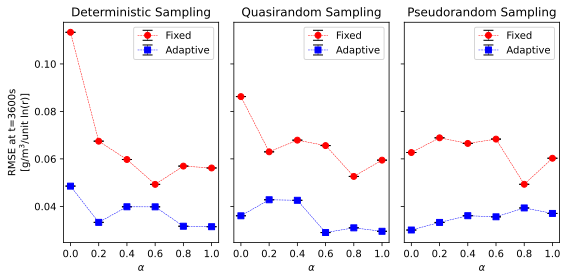

In [3]:
fig, axes = pyplot.subplot_mosaic(
    ([['deterministic','quasirandom','pseudorandom']]),
    figsize=(8, 4),
    tight_layout=True,
    sharey=True,
)
for sampling in ('deterministic','quasirandom','pseudorandom'):
    for adaptive, kwargs in {
        False: {'marker':'o', 'color':'red', 'label':'Fixed'},
        True: {'marker':'s', 'color':'blue', 'label':'Adaptive'},
    }.items():
        axes[sampling].errorbar(
            alphas,
            np.array(errors_all[f'{adaptive}_{sampling}']),
            yerr=np.array(errors_std_all[f'{adaptive}_{sampling}']),
            ls='--',
            lw=0.5, 
            capsize=5,
            capthick=1,
            ecolor='black',
            **kwargs
        )
    axes[sampling].legend()
    axes[sampling].set(
        title=f"{sampling.capitalize()} Sampling",
        xlabel=r'$\alpha$',
        xticks = alphas,
    )
axes['deterministic'].set(
    ylabel=f"RMSE at t=3600s\n[g/m$^3$/unit ln(r)]",
)
show_plot("fig_5")